
✅ Model loaded successfully.


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:14<00:00,  5.56it/s]


📉 Average L1 Loss on Validation Set: 0.1005


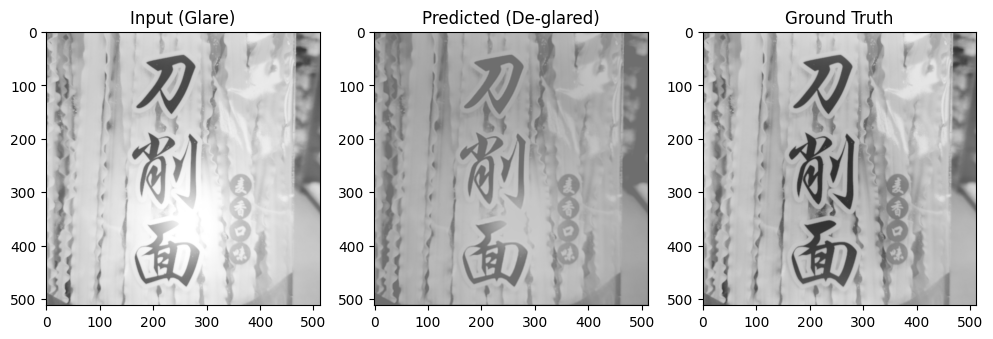

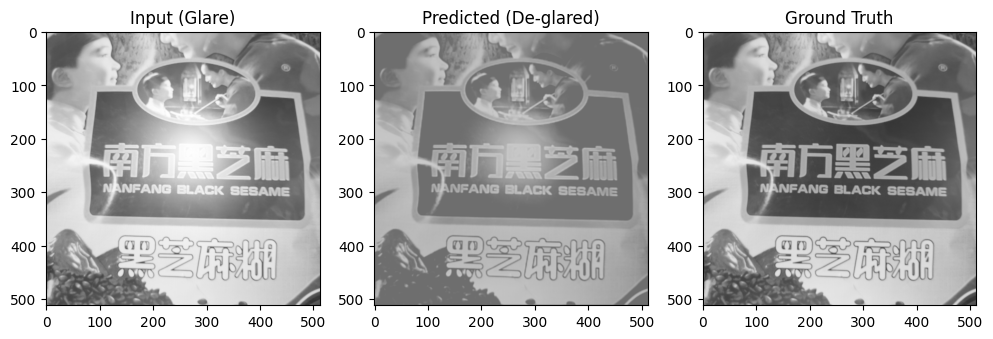

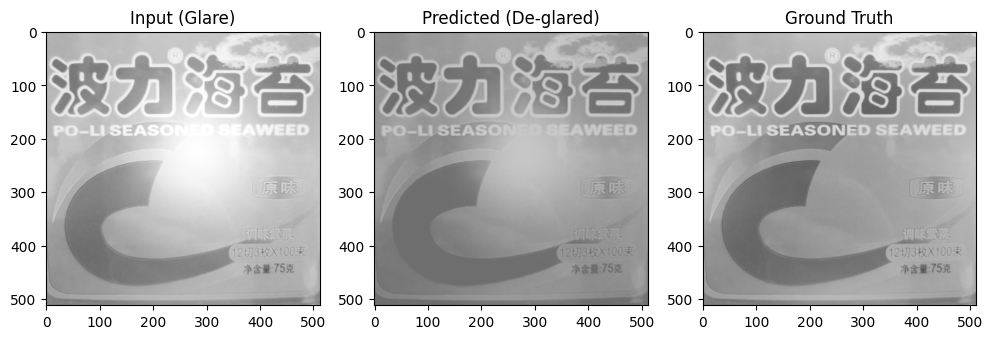

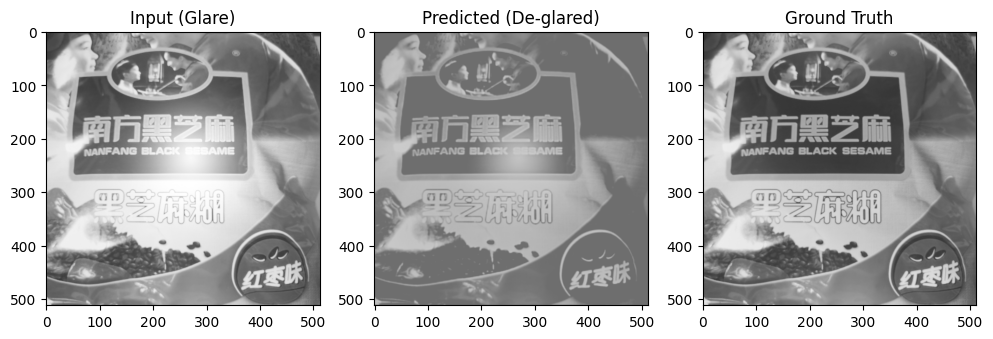

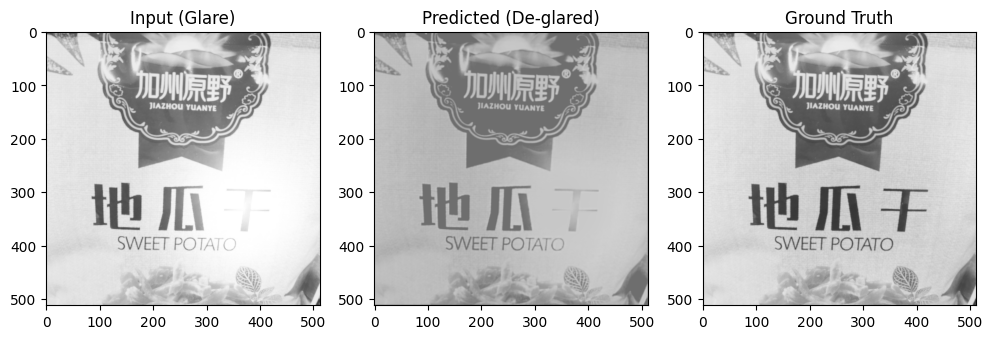

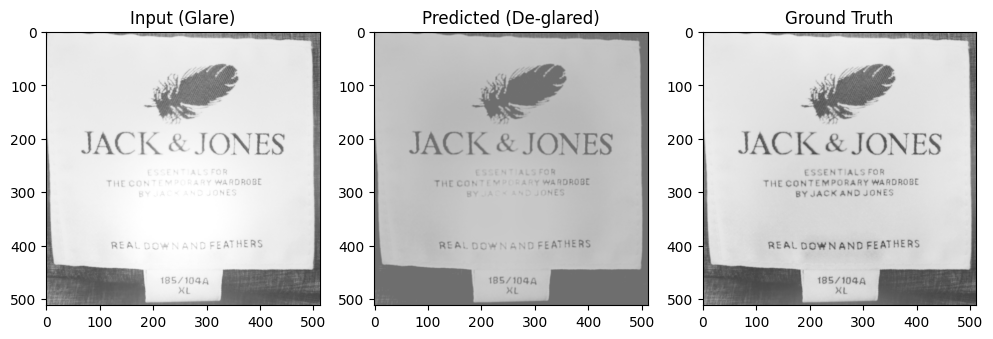

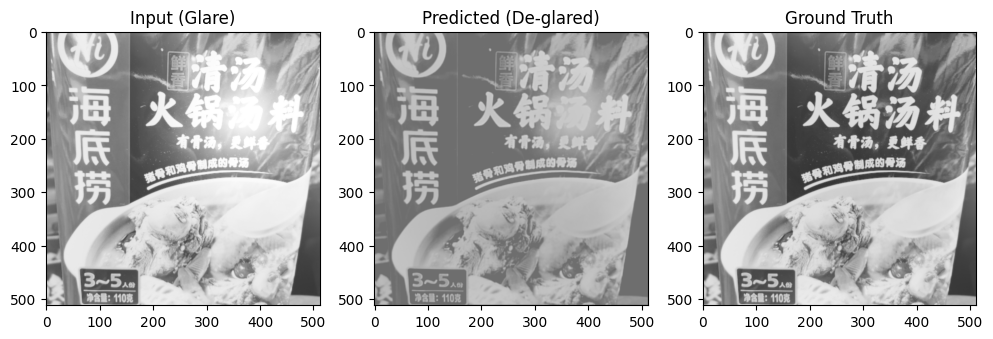

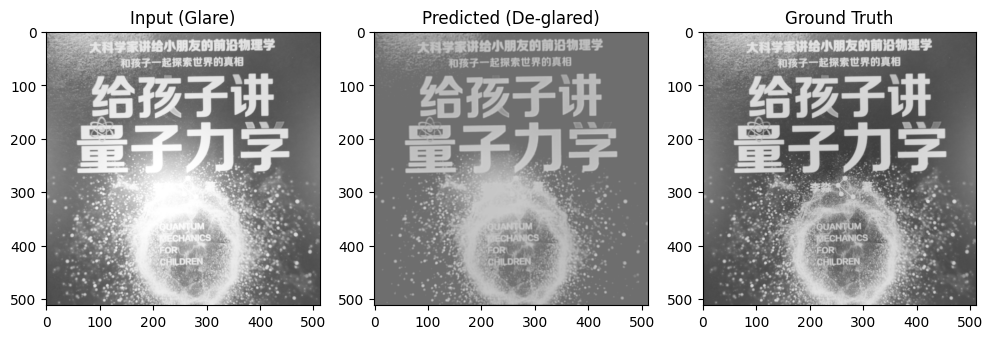

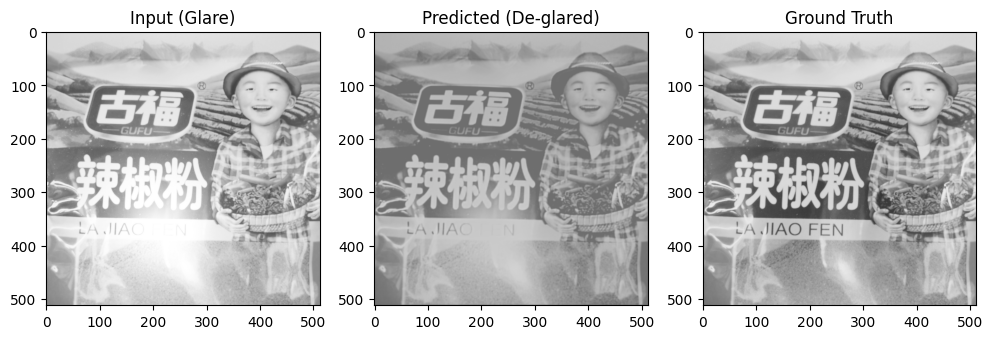

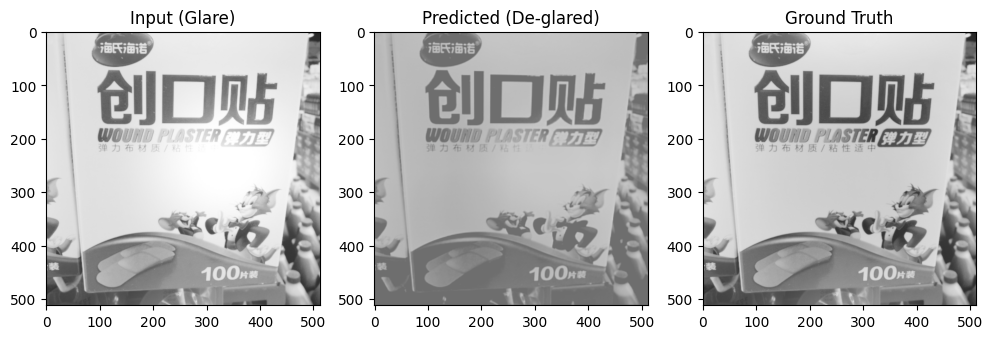

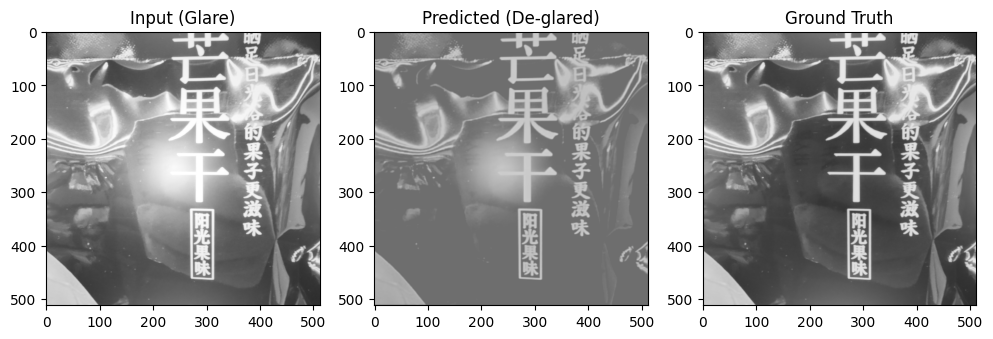

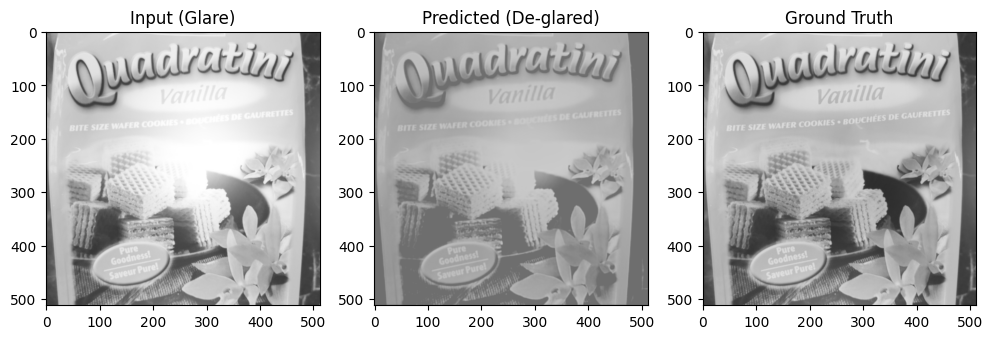

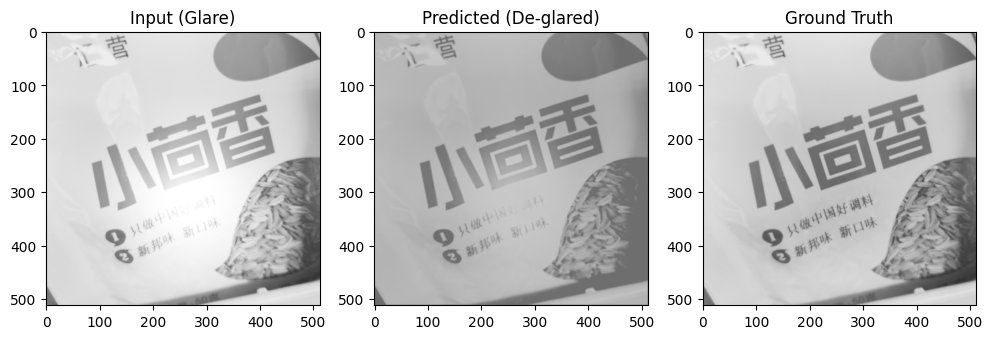

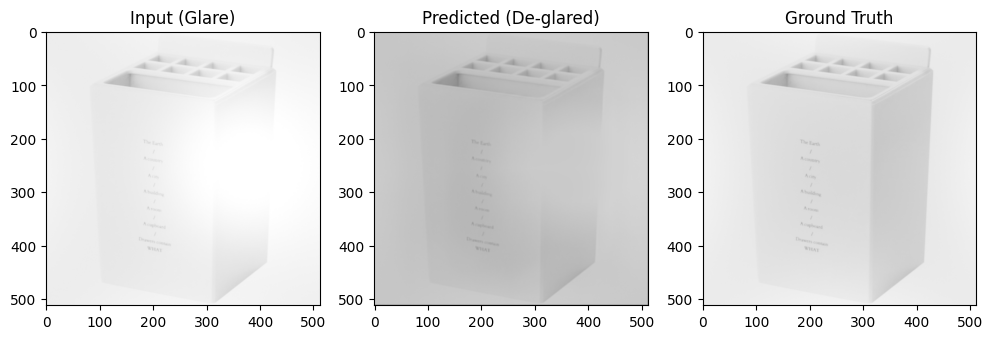

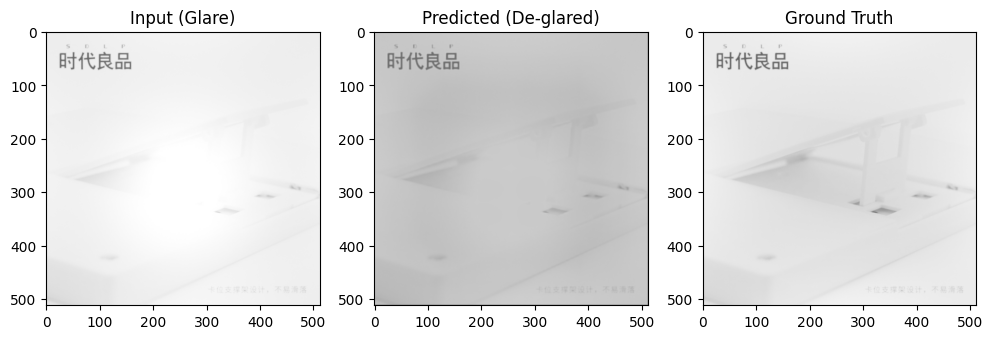

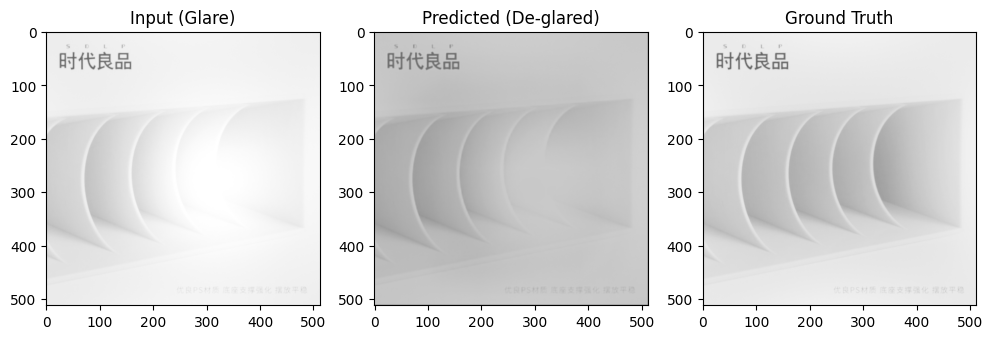

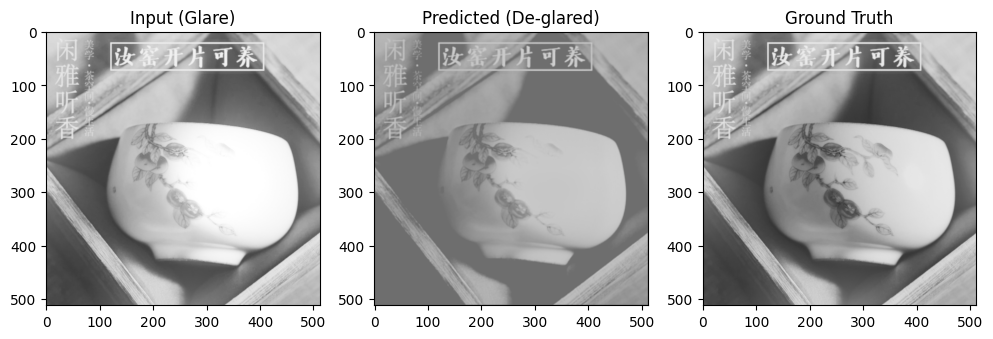

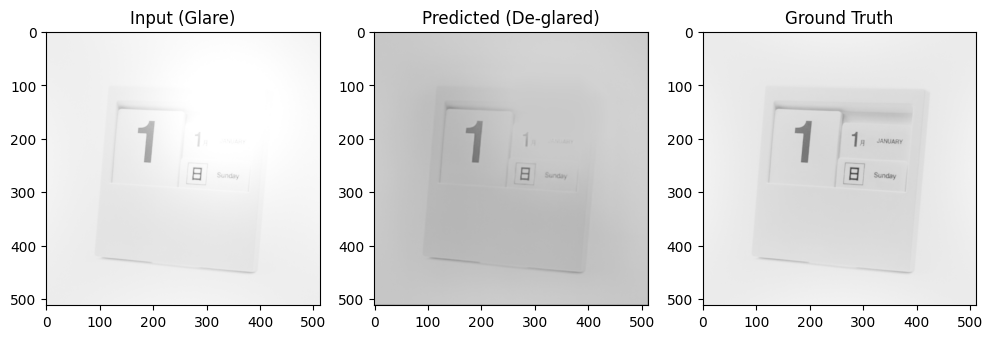

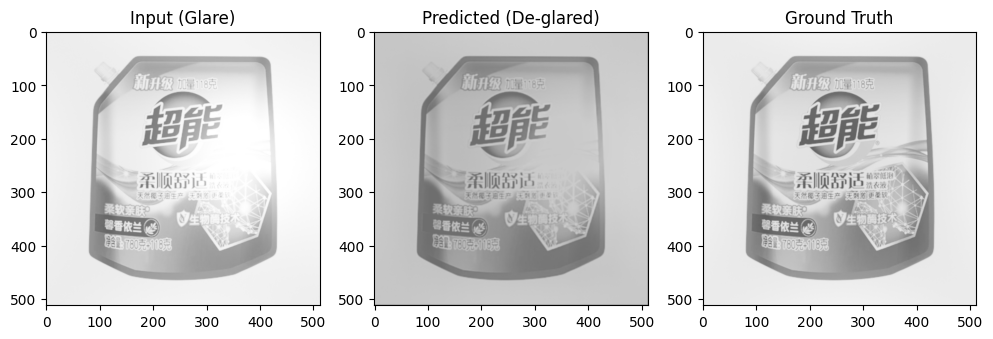

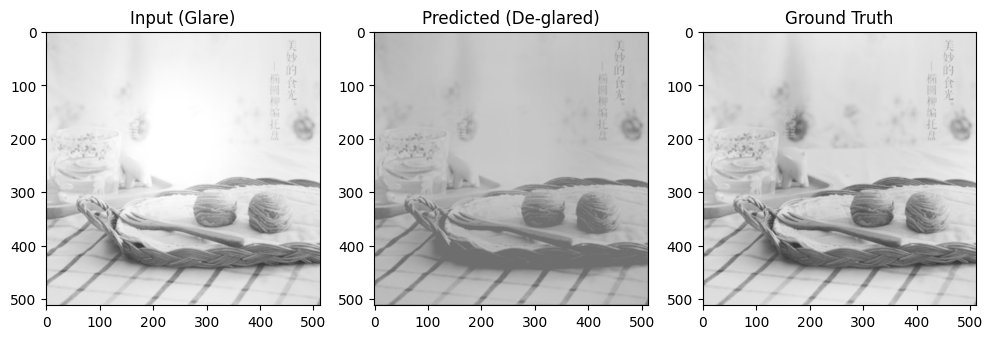

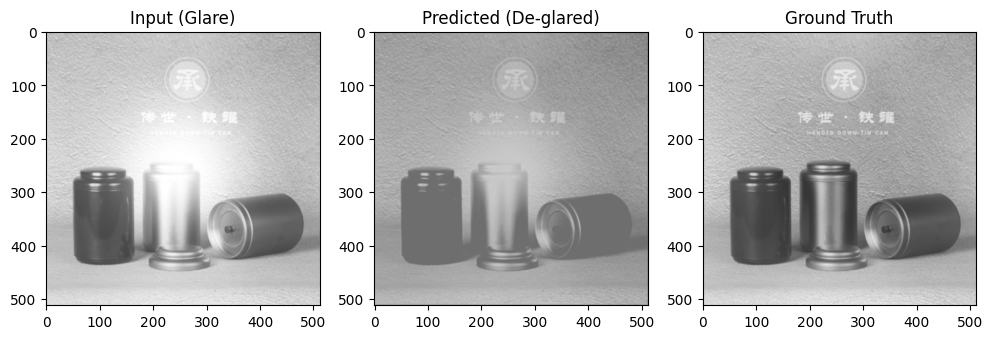

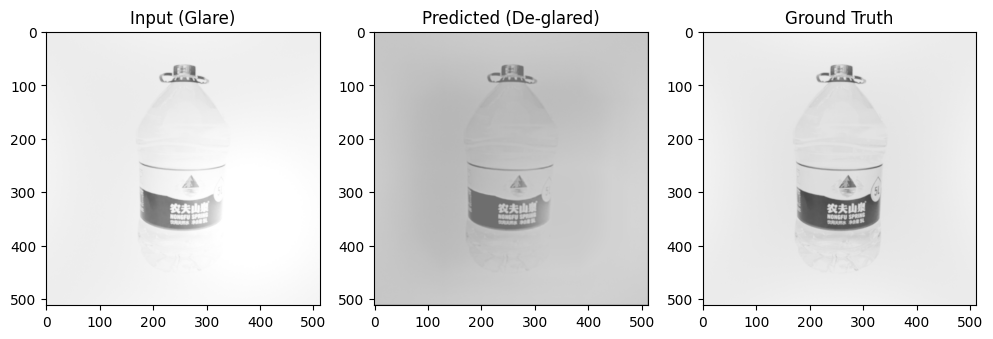

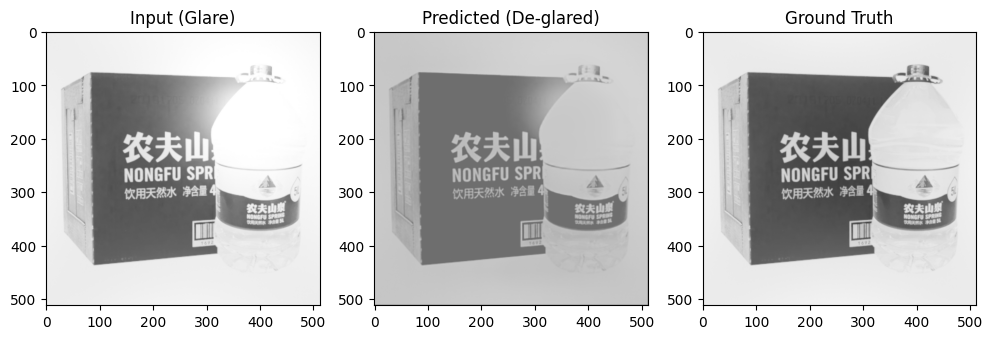

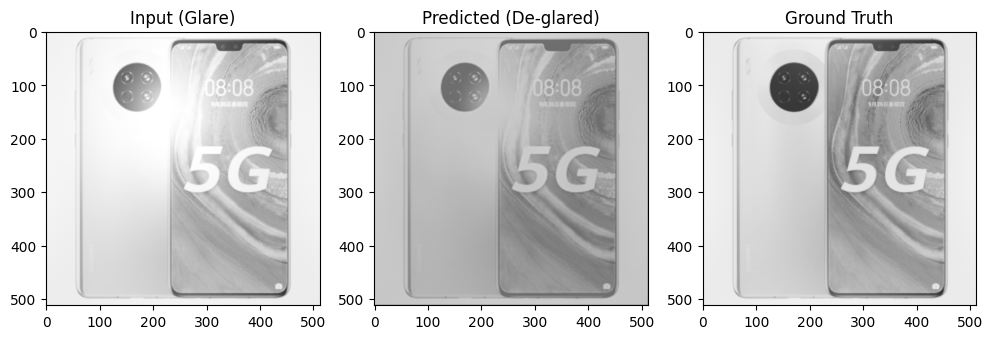

In [2]:
# Install necessary packages
!pip install torch torchvision matplotlib tqdm

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.dirname(os.getcwd()))

from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# ✅ Import your trained Auto model
from models.autoencoder.auto import Auto  # Ensure this path is correct

# ✅ Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define dataset paths
DATA_DIR = Path("../data/SD1")
PROCESSED_VAL_DIR = DATA_DIR / "processed_val"
MODEL_PATH = Path("../models/final_glare_removal_autoencoder.pth")  # ✅ Ensure path is correct

# ✅ Define Dataset Class
class GlareRemovalDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, _transform=None):
        self.root_dir = Path(root_dir)
        self.transform = _transform
        self.image_pairs = []

        # Collect glare/gt image pairs
        for glare_img in sorted(self.root_dir.glob("glare_*.png")):
            gt_img = self.root_dir / glare_img.name.replace("glare_", "gt_")
            if gt_img.exists():
                self.image_pairs.append((glare_img, gt_img))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        glare_path, gt_path = self.image_pairs[idx]
        glare_img = Image.open(glare_path).convert("RGB")
        gt_img = Image.open(gt_path).convert("RGB")

        if self.transform:
            glare_img = self.transform(glare_img)
            gt_img = self.transform(gt_img)

        return glare_img, gt_img

# ✅ Define Transformations
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# ✅ Load validation dataset
val_dataset = GlareRemovalDataset(PROCESSED_VAL_DIR, transform_pipeline)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# ✅ Load trained model
model = Auto().to(device)  # ✅ Use the same model architecture as in training
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # ✅ Load trained weights
model.eval()  # ✅ Set model to evaluation mode
print("✅ Model loaded successfully.")

# ✅ Define loss function (L1 Loss)
criterion = nn.L1Loss()

# ✅ Evaluate model on validation dataset
total_loss = 0.0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)  # ✅ Forward pass through the trained model
        loss = criterion(outputs, targets)
        total_loss += loss.item()

# ✅ Print average L1 loss
avg_loss = total_loss / len(val_loader)
print(f"📉 Average L1 Loss on Validation Set: {avg_loss:.4f}")

# ✅ Function to visualize predictions
def show_images(original, predicted, ground_truth):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original.permute(1, 2, 0))
    axes[0].set_title("Input (Glare)")
    axes[1].imshow(predicted.permute(1, 2, 0).clip(0, 1))  # ✅ Clamp values for display
    axes[1].set_title("Predicted (De-glared)")
    axes[2].imshow(ground_truth.permute(1, 2, 0))
    axes[2].set_title("Ground Truth")
    plt.show()

# ✅ Display a few predictions
for i, (images, targets) in enumerate(val_loader):
    if i == 3:  # ✅ Show 3 batches
        break
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(images)  # ✅ Get model predictions
    for j in range(len(images)):
        show_images(images[j].cpu(), outputs[j].cpu(), targets[j].cpu())
